In [1]:
cd /home/r09222027/GitHub/Annealing-Algorithms/Simulated Quantum Annealing

/home/r09222027/GitHub/Annealing-Algorithms/Simulated Quantum Annealing


In [2]:
import numpy as np
import scipy as sp
from scipy.optimize import minimize
from scipy.sparse import csr_matrix, block_diag
import matplotlib.pyplot as plt
from tqdm import tqdm
from sqa import one_SQA_run
from multiprocessing import Pool
import os
%matplotlib inline

## Functions and Parameters Definitions

In [3]:
def Ising_from_maxcut_file(abs_file_path):
    """
    Import an MaxCut problem from file, and turn it into Ising form.
    
    Parameters:
        abs_file_path (str): The absolute file path for the MaxCut instance file.
    
    Return: CSR sparse matrix in Ising form.
    """
    
    with open(abs_file_path, 'r') as f:
        coef_lst = f.read().split()
    
    A = csr_matrix(([int(x) for x in coef_lst[4::3]], ([int(x)-1 for x in coef_lst[2::3]], \
                    [int(x)-1 for x in coef_lst[3::3]])), shape=(int(coef_lst[0]), int(coef_lst[0])))

    return (A + A.T)/4

In [4]:
# J matirces from maxcut problem files
J_dict = dict()
for N in [60, 80, 100]:
    for ins in range(10):
        abs_file_path = f"/home/r09222027/GitHub/Annealing-Algorithms/Simulated Bifurcation/mac_all/rudy/g05_{N}.{ins}" # absolute dir
        J_dict[(N, ins)] = Ising_from_maxcut_file(abs_file_path)

In [5]:
# best known solution for the g05 dataset
opt_cut = {60: [536, 532, 529, 538, 527, 533, 531, 535, 530, 533], \
           80: [929, 941, 934, 923, 932, 926, 929, 929, 925, 923], \
           100: [1430, 1425, 1432, 1424, 1440, 1436, 1434, 1431, 1432, 1430]}

In [6]:
def get_cut_val(N, ins, M, T, Gamma0, Gamma1, steps, normalize_J=True, rng_sd=None, fun=one_SQA_run):
    # abs_file_path = f"/home/r09222027/GitHub/Annealing-Algorithms/Simulated Bifurcation/mac_all/rudy/g05_{N}.{ins}" # absolute dir
    # J = Ising_from_maxcut_file(abs_file_path)
    J = J_dict[(N, ins)]
    h = np.zeros(J.shape[0])

    if normalize_J:
        j = J / (np.sqrt(np.sum(J**2) / (J.shape[0] - 1))) # normalization
    
    r = (Gamma1 / Gamma0)**(1/(steps-1)) # Gamma1 is the final Gamma
    Gamma_sched = [Gamma0 * r**i for i in range(steps)]

    fin_state = np.sign(fun(J, h, Gamma_sched, M, T, sd=rng_sd, return_pauli_z=True))
    fin_energy = fin_state.dot(J.dot(fin_state))

    return int(np.sum(J) - fin_energy) # cut value

In [7]:
M_lst = [5, 9, 17, 33, 65]
T_lst = [1, 0.1, 0.01]
Gamma0_lst = [10]
Gamma1_lst = [1e-3]
steps_lst = [100]

In [8]:
num_rep = 10
args_lst = []
for M in M_lst:
    for T in T_lst:
        for Gamma0 in Gamma0_lst:
            for Gamma1 in Gamma1_lst:
                for sweeps_per_spin in steps_lst:
                    for N in [60, 80, 100]:
                        for ins in range(10):
                            for _ in range(num_rep):
                                args_lst.append((N, ins, M, T, Gamma0, Gamma1, sweeps_per_spin))

In [39]:
def wrapper(args):
    N, ins, M, T, Gamma0, Gamma1, sweeps_per_spin = args
    J = J_dict[(N, ins)]
    return get_cut_val(N, ins, M, T, Gamma0, Gamma1, sweeps_per_spin)

In [40]:
with Pool(os.cpu_count()//2) as p:
    results_rev = list(tqdm(p.imap(wrapper, args_lst), total=len(args_lst)))

# storing the results
with open('benchmark_results.csv', 'a') as f:
    # f.write(f"N,ins,M,T,Gamma0,Gamma1,steps,results")
    prev_args = None
    for args, cut in zip(args_lst, results_rev):
        N, ins, M, T, Gamma0, Gamma1, steps = args
        if prev_args != args:
            f.write(f"\n{N},{ins},{M},{T},{Gamma0},{Gamma1},{steps},{cut}")
            prev_args = args
        else:
            f.write(f",{cut}")

100%|██████████| 4500/4500 [3:24:33<00:00,  2.73s/it]  


In [9]:
# retrieving the results from csv file
data = dict() # cut values
with open('benchmark_results.csv', 'r') as f:
    header = f.readline()
    line = f.readline()
    while line:
        entries = line.split(',')
        N = int(entries[0])
        ins = int(entries[1])
        M = int(entries[2])
        T = float(entries[3])
        Gamma0 = float(entries[4])
        Gamma1 = float(entries[5])
        steps = int(entries[6])
        if (N, ins, M, T, Gamma0, Gamma1, steps) not in data:
            data[(N, ins, M, T, Gamma0, Gamma1, steps)] = [int(x) for x in entries[7:]]
        else:
            data[(N, ins, M, T, Gamma0, Gamma1, steps)].extend([int(x) for x in entries[7:]])
        line = f.readline()

In [36]:
target = 1
for Gamma0 in Gamma0_lst:
    for Gamma1 in Gamma1_lst:
        for T in T_lst:
            for M in M_lst:
                success_count = 0
                total_count = 0
                for ins in range(10):
                    success_count += sum([x >= (opt_cut[60][ins] * target) for x in data[(60, ins, M, T, Gamma0, Gamma1, 100)]])
                    total_count += len(data[(60, ins, M, T, Gamma0, Gamma1, 100)])
                print(f"For M={M}, {success_count} out of {total_count} runs successfully reached {100*target}% of optimal cut value")

For M=5, 61 out of 200 runs successfully reached 100% of optimal cut value
For M=9, 25 out of 100 runs successfully reached 100% of optimal cut value
For M=17, 86 out of 200 runs successfully reached 100% of optimal cut value
For M=33, 31 out of 100 runs successfully reached 100% of optimal cut value
For M=65, 10 out of 100 runs successfully reached 100% of optimal cut value


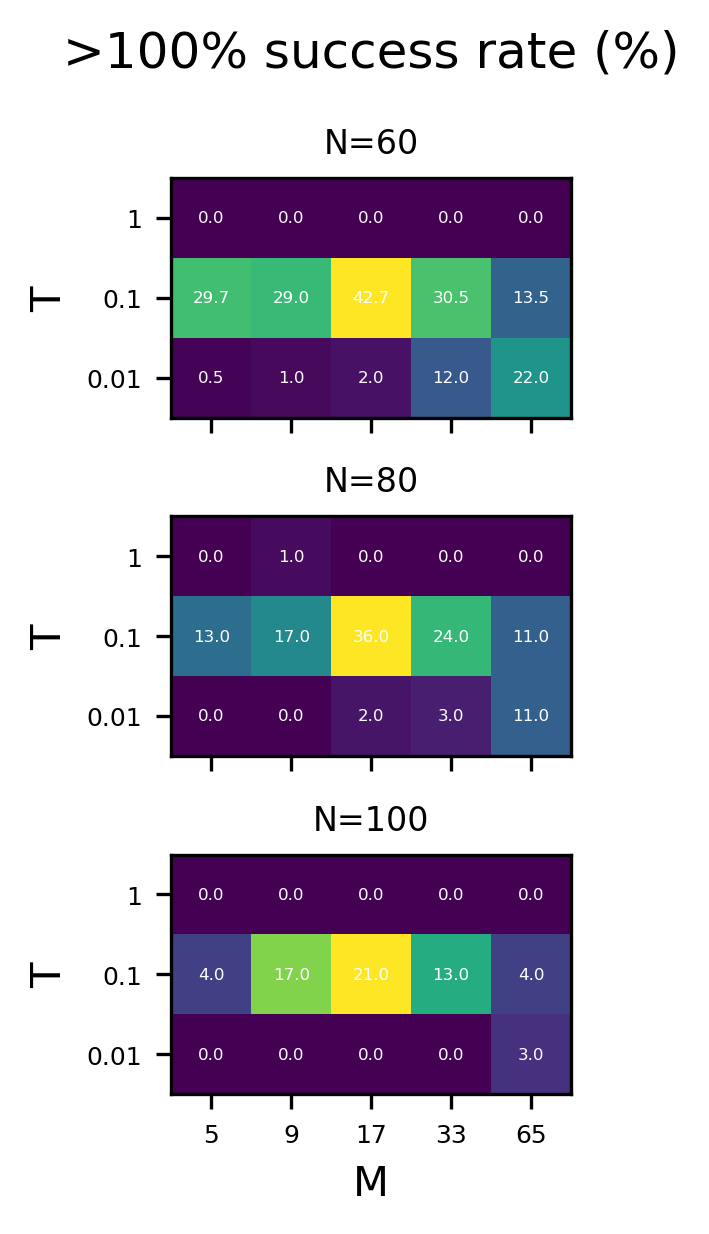

In [12]:
target = 1

fig, axs = plt.subplots(3, 1, dpi=300, constrained_layout=True, sharex=True, sharey=True)
fig.suptitle(f">{100*target}% success rate (%)")
plt.setp(axs[-1], xlabel="M")
plt.setp(axs[:], ylabel="T")

Gamma0, Gamma1, steps = 10, 0.001, 100

xdata = M_lst
ydata = T_lst

for i, N in enumerate([60, 80, 100]):
    ax = axs[i]
    best_cut_count_data = np.zeros((len(ydata), len(xdata)))
    total_count_data = np.zeros((len(ydata), len(xdata)))
    for ins in range(10):
        for x, M in enumerate(xdata):
            for y, T in enumerate(ydata):
                best_cut_count_data[y, x] += sum([x >= target * opt_cut[N][ins] for x in data[(N, ins, M, T, Gamma0, Gamma1, steps)]])
                total_count_data[y, x] += len(data[(N, ins, M, T, Gamma0, Gamma1, steps)])

    success_rate_data = best_cut_count_data / total_count_data

    ax.imshow(success_rate_data)

    ax.set_xticks(np.arange(len(xdata)))
    ax.set_yticks(np.arange(len(ydata)))
    ax.set_xticklabels(xdata, size=6)
    ax.set_yticklabels(ydata, size=6)
    # ax.set_xlabel("c0")
    # ax.set_ylabel("dt")
    ax.set_title(f"N={N}", size=8)

    # Loop over data dimensions and create text annotations.
    for i in range(len(ydata)):
        for j in range(len(xdata)):
            text = ax.text(j, i, f"{100*success_rate_data[i, j]:.1f}",
                        ha="center", va="center", color="w", size=4)

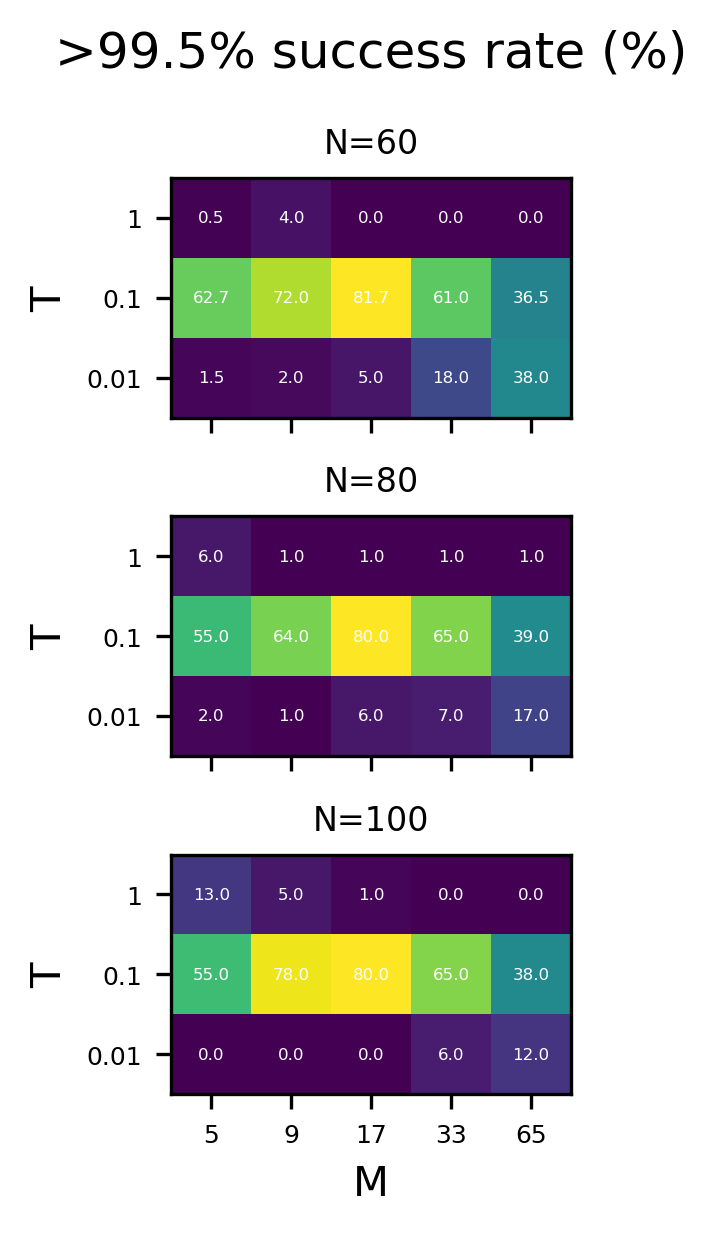

In [13]:
target = 0.995

fig, axs = plt.subplots(3, 1, dpi=300, constrained_layout=True, sharex=True, sharey=True)
fig.suptitle(f">{100*target}% success rate (%)")
plt.setp(axs[-1], xlabel="M")
plt.setp(axs[:], ylabel="T")

Gamma0, Gamma1, steps = 10, 0.001, 100

xdata = M_lst
ydata = T_lst

for i, N in enumerate([60, 80, 100]):
    ax = axs[i]
    best_cut_count_data = np.zeros((len(ydata), len(xdata)))
    total_count_data = np.zeros((len(ydata), len(xdata)))
    for ins in range(10):
        for x, M in enumerate(xdata):
            for y, T in enumerate(ydata):
                best_cut_count_data[y, x] += sum([x >= target * opt_cut[N][ins] for x in data[(N, ins, M, T, Gamma0, Gamma1, steps)]])
                total_count_data[y, x] += len(data[(N, ins, M, T, Gamma0, Gamma1, steps)])

    success_rate_data = best_cut_count_data / total_count_data

    ax.imshow(success_rate_data)

    ax.set_xticks(np.arange(len(xdata)))
    ax.set_yticks(np.arange(len(ydata)))
    ax.set_xticklabels(xdata, size=6)
    ax.set_yticklabels(ydata, size=6)
    # ax.set_xlabel("c0")
    # ax.set_ylabel("dt")
    ax.set_title(f"N={N}", size=8)

    # Loop over data dimensions and create text annotations.
    for i in range(len(ydata)):
        for j in range(len(xdata)):
            text = ax.text(j, i, f"{100*success_rate_data[i, j]:.1f}",
                        ha="center", va="center", color="w", size=4)

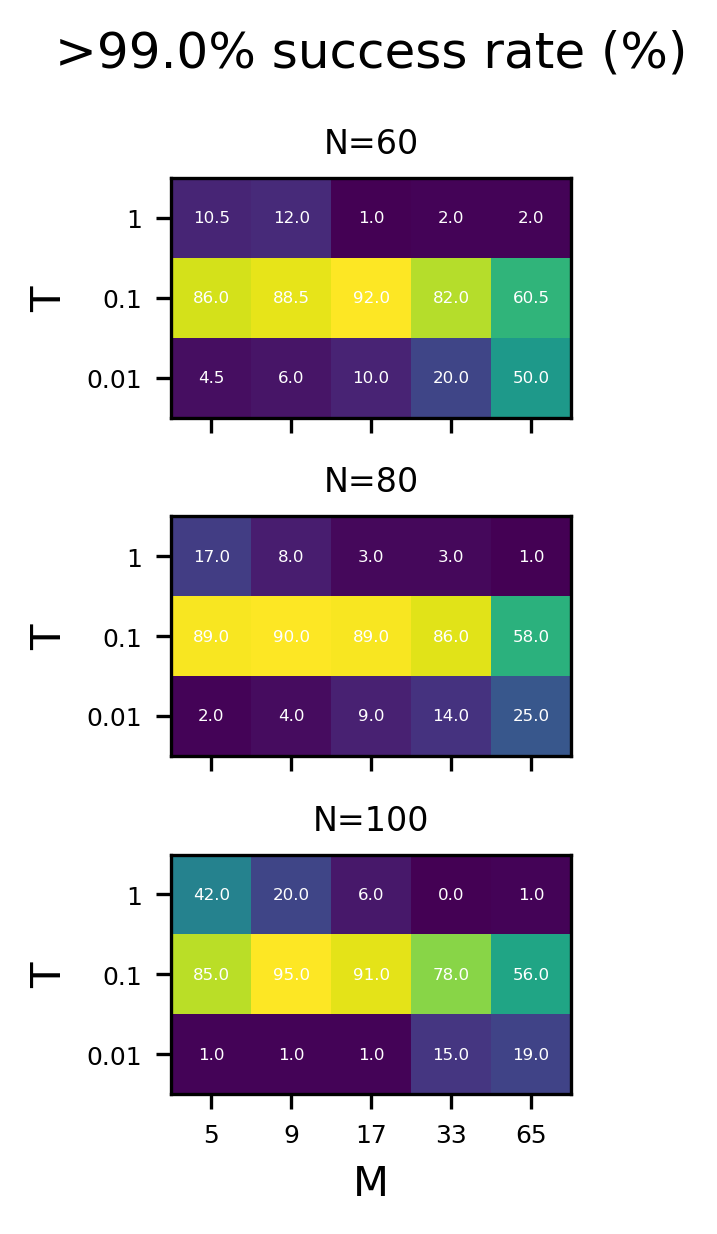

In [14]:
target = 0.99

fig, axs = plt.subplots(3, 1, dpi=300, constrained_layout=True, sharex=True, sharey=True)
fig.suptitle(f">{100*target}% success rate (%)")
plt.setp(axs[-1], xlabel="M")
plt.setp(axs[:], ylabel="T")

Gamma0, Gamma1, steps = 10, 0.001, 100

xdata = M_lst
ydata = T_lst

for i, N in enumerate([60, 80, 100]):
    ax = axs[i]
    best_cut_count_data = np.zeros((len(ydata), len(xdata)))
    total_count_data = np.zeros((len(ydata), len(xdata)))
    for ins in range(10):
        for x, M in enumerate(xdata):
            for y, T in enumerate(ydata):
                best_cut_count_data[y, x] += sum([x >= target * opt_cut[N][ins] for x in data[(N, ins, M, T, Gamma0, Gamma1, steps)]])
                total_count_data[y, x] += len(data[(N, ins, M, T, Gamma0, Gamma1, steps)])

    success_rate_data = best_cut_count_data / total_count_data

    ax.imshow(success_rate_data)

    ax.set_xticks(np.arange(len(xdata)))
    ax.set_yticks(np.arange(len(ydata)))
    ax.set_xticklabels(xdata, size=6)
    ax.set_yticklabels(ydata, size=6)
    # ax.set_xlabel("c0")
    # ax.set_ylabel("dt")
    ax.set_title(f"N={N}", size=8)

    # Loop over data dimensions and create text annotations.
    for i in range(len(ydata)):
        for j in range(len(xdata)):
            text = ax.text(j, i, f"{100*success_rate_data[i, j]:.1f}",
                        ha="center", va="center", color="w", size=4)

### Case study: N=100, M=9, T=0.1

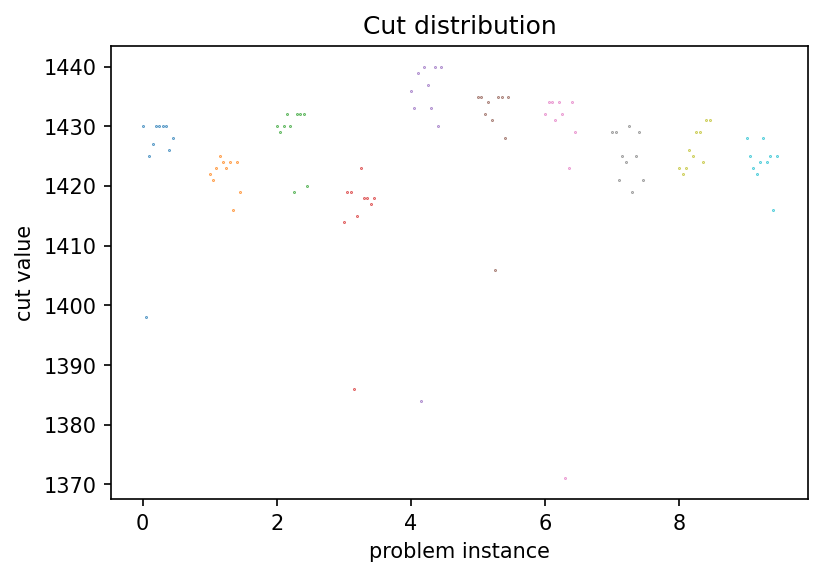

In [10]:
N, ins, M, T, Gamma0, Gamma1, steps = 100, 0, 9, 0.1, 10, 0.001, 100

fig = plt.figure(dpi=150)
plt.title("Cut distribution")
plt.xlabel("problem instance")
plt.ylabel("cut value")

for ins in range(10):
    x_data = 0.5/len(data[(N, ins, M, T, Gamma0, Gamma1, steps)])*np.arange(len(data[(N, ins, M, T, Gamma0, Gamma1, steps)])) + ins
    plt.scatter(x_data, data[(N, ins, M, T, Gamma0, Gamma1, steps)], s=0.1)

## Problems with 2K nodes

### G22

In [7]:
J = Ising_from_maxcut_file("/home/r09222027/GitHub/Annealing-Algorithms/Simulated Bifurcation/Gset/G22.txt")
j = J / (np.sqrt(np.sum(J**2) / (J.shape[0] - 1))) # normalized

In [10]:
M_lst = [9, 17, 33]
T_lst = [1, 0.1, 0.01]
Gamma0_lst = [10]
Gamma1_lst = [1e-3]
steps_lst = [100]

In [11]:
num_rep = 10
args_lst = []
for M in M_lst:
    for T in T_lst:
        for Gamma0 in Gamma0_lst:
            for Gamma1 in Gamma1_lst:
                for sweeps_per_spin in steps_lst:
                        for _ in range(num_rep):
                            args_lst.append((M, T, Gamma0, Gamma1, sweeps_per_spin))

In [14]:
def get_G22_cut_val(args):
    M, T, Gamma0, Gamma1, sweeps_per_spin = args

    h = np.zeros(J.shape[0])
    
    r = (Gamma1 / Gamma0)**(1/(sweeps_per_spin-1)) # Gamma1 is the final Gamma
    Gamma_sched = [Gamma0 * r**i for i in range(sweeps_per_spin)]
    
    fin_state = np.sign(one_SQA_run(j, h, Gamma_sched, M, T, sd=None, return_pauli_z=True))
    fin_energy = fin_state.dot(J.dot(fin_state))

    return int(np.sum(J) - fin_energy) # cut value

In [15]:
with Pool(os.cpu_count()//2) as p:
    results_rev = list(tqdm(p.imap(get_G22_cut_val, args_lst), total=len(args_lst)))

# storing the results
with open('G22_benchmark_results.csv', 'a') as f:
    f.write(f"M,T,Gamma0,Gamma1,steps,results")
    prev_args = None
    for args, cut in zip(args_lst, results_rev):
        M, T, Gamma0, Gamma1, steps = args
        if prev_args != args:
            f.write(f"\n{M},{T},{Gamma0},{Gamma1},{steps},{cut}")
            prev_args = args
        else:
            f.write(f",{cut}")

  8%|▊         | 7/90 [2:30:08<17:36:30, 763.74s/it]  

In [100]:
opt_cut_G22 = 13359 # best known cut value for G22

In [101]:
data = dict()
for args, cut in zip(args_lst, results_rev):
    if args not in data:
        data[args] = [cut]
    else:
        data[args].append(cut)

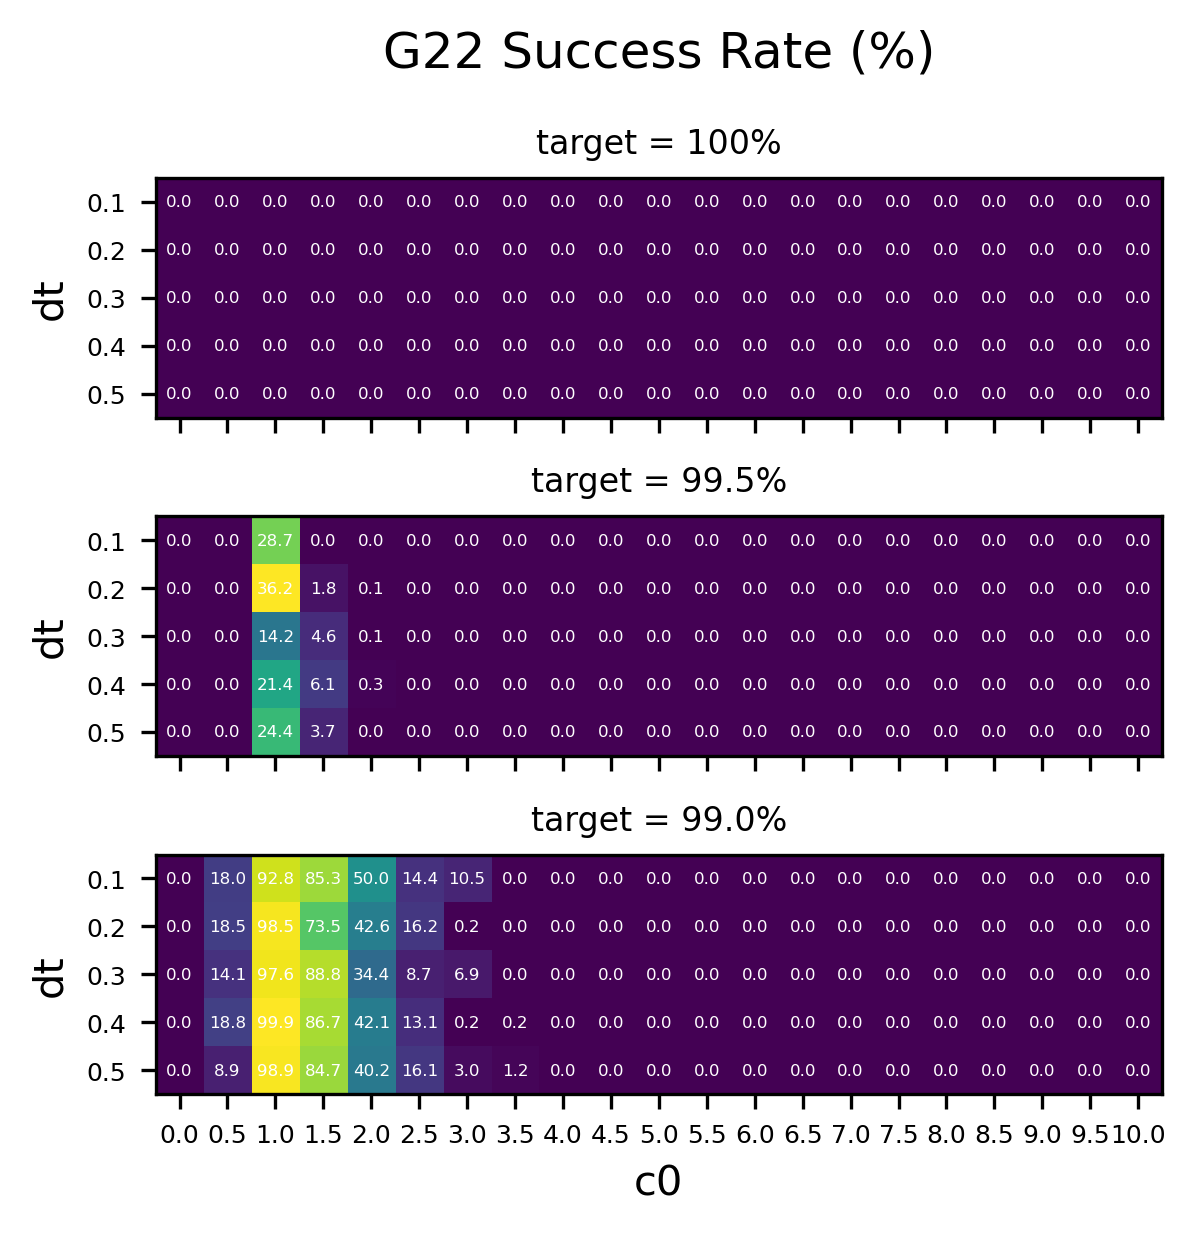

In [102]:
fig, axs = plt.subplots(3, 1, dpi=300, constrained_layout=True, sharex=True, sharey=True)
fig.suptitle("G22 Success Rate (%)")
plt.setp(axs[-1], xlabel="c0")
plt.setp(axs[:], ylabel="dt")

for i, r in enumerate([1, 0.995, 0.99]):
    ax = axs[i]
    best_cut_count_data = np.zeros((len(dt_lst), len(c0_lst)))
    total_count_data = np.zeros((len(dt_lst), len(c0_lst)))
    for ins in range(10):
        for x, c0 in enumerate(c0_lst):
            for y, dt in enumerate(dt_lst):
                best_cut_count_data[y, x] += sum([x >= r * opt_cut_G22 for x in data[(dt, c0)]])
                total_count_data[y, x] += len(data[(dt, c0)])

    success_rate_data = best_cut_count_data / total_count_data

    ax.imshow(success_rate_data)

    ax.set_xticks(np.arange(len(c0_lst)))
    ax.set_yticks(np.arange(len(dt_lst)))
    ax.set_xticklabels(c0_lst, size=6)
    ax.set_yticklabels(dt_lst, size=6)
    # ax.set_xlabel("c0")
    # ax.set_ylabel("dt")
    ax.set_title(f"target = {100*r}%", size=8)

    # Loop over data dimensions and create text annotations.
    for i in range(len(dt_lst)):
        for j in range(len(c0_lst)):
            text = ax.text(j, i, f"{100*success_rate_data[i, j]:.1f}",
                        ha="center", va="center", color="w", size=4)

### Case study: (dt, c0) = (0.3, 1.0)

In [106]:
dt, c0 = 0.3, 1.0
PS = [a0*i/(int(150/dt)-1) for i in range(int(150/dt))]
result, x_history = one_dSB_run(j, PS, dt, c0, init_y=None, return_x_history=True)

Text(0, 0.5, 'x')

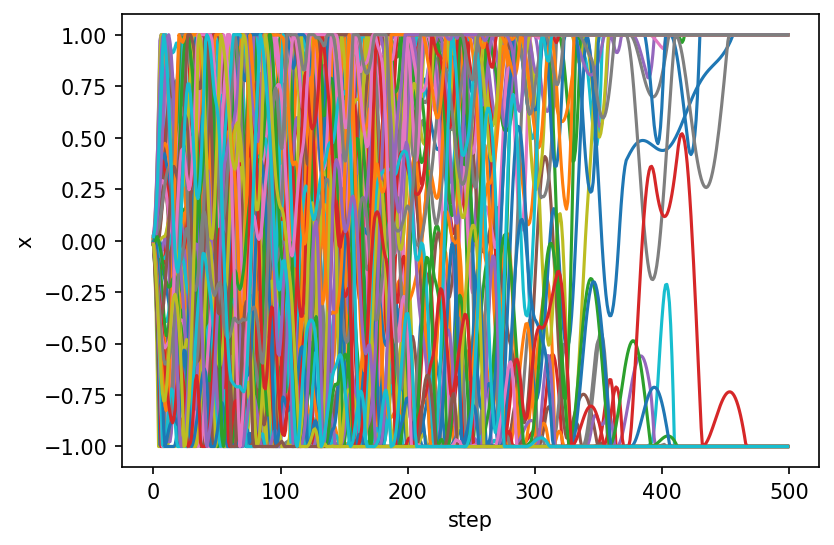

In [107]:
plt.figure(dpi=150)

for i in range(N):
    plt.plot(np.array(x_history)[:, i], label=f'{i}')

plt.xlabel('step')
plt.ylabel('x')

### WK2000

In [163]:
cd /home/r09222027/GitHub/Annealing-Algorithms/Simulated Bifurcation/SA-complete-graph-WK2000

/home/r09222027/GitHub/Annealing-Algorithms/Simulated Bifurcation/SA-complete-graph-WK2000


In [206]:
J = Ising_from_maxcut_file("WK2000_1.rud")
j = J / (np.sqrt(np.sum(J**2) / (J.shape[0] - 1))) # normalized

In [207]:
def get_WK2000_cut_val(args):
    dt, c0 = args
    PS = [a0*i/(int(150/dt)-1) for i in range(int(150/dt))]
    init_y = 0.01 * rng.uniform(low=-1, high=1, size=j.shape[0])
    
    fin_state = one_dSB_run(j, PS, dt, c0, init_y=init_y, return_x_history=False)
    fin_energy = fin_state.dot(J.dot(fin_state))

    return int(np.sum(J) - fin_energy) # cut value

In [208]:
num_rep = 1000
a0 = 1

dt_lst = [0.125, 0.25, 0.375]
c0_lst = [0.5*x for x in range(1, 11)]

In [209]:
args_lst = []
for dt in dt_lst:
    for c0 in c0_lst:
        for _ in range(num_rep):
            args_lst.append((dt, c0))

In [210]:
rng = np.random.default_rng(0)

In [211]:
with Pool(os.cpu_count()//2) as p:
    results_rev = list(tqdm(p.imap(get_WK2000_cut_val, args_lst), total=len(args_lst)))

# storing the results
with open('WK2000_benchmark_results.csv', 'a') as f:
    f.write(f"dt,c0,results")
    prev_args = None
    for args, cut in zip(args_lst, results_rev):
        dt, c0 = args
        if prev_args != args:
            f.write(f"\n{dt},{c0},{cut}")
            prev_args = args
        else:
            f.write(f",{cut}")

 72%|███████▏  | 21529/30000 [1:53:28<22:22,  6.31it/s]  

In [212]:
data = dict()
for args, cut in zip(args_lst, results_rev):
    if args not in data:
        data[args] = [cut]
    else:
        data[args].append(cut)

In [203]:
# largest cut value for WK2000 in the original paper: science.aah4243
opt_cut_WK2000 = 33191

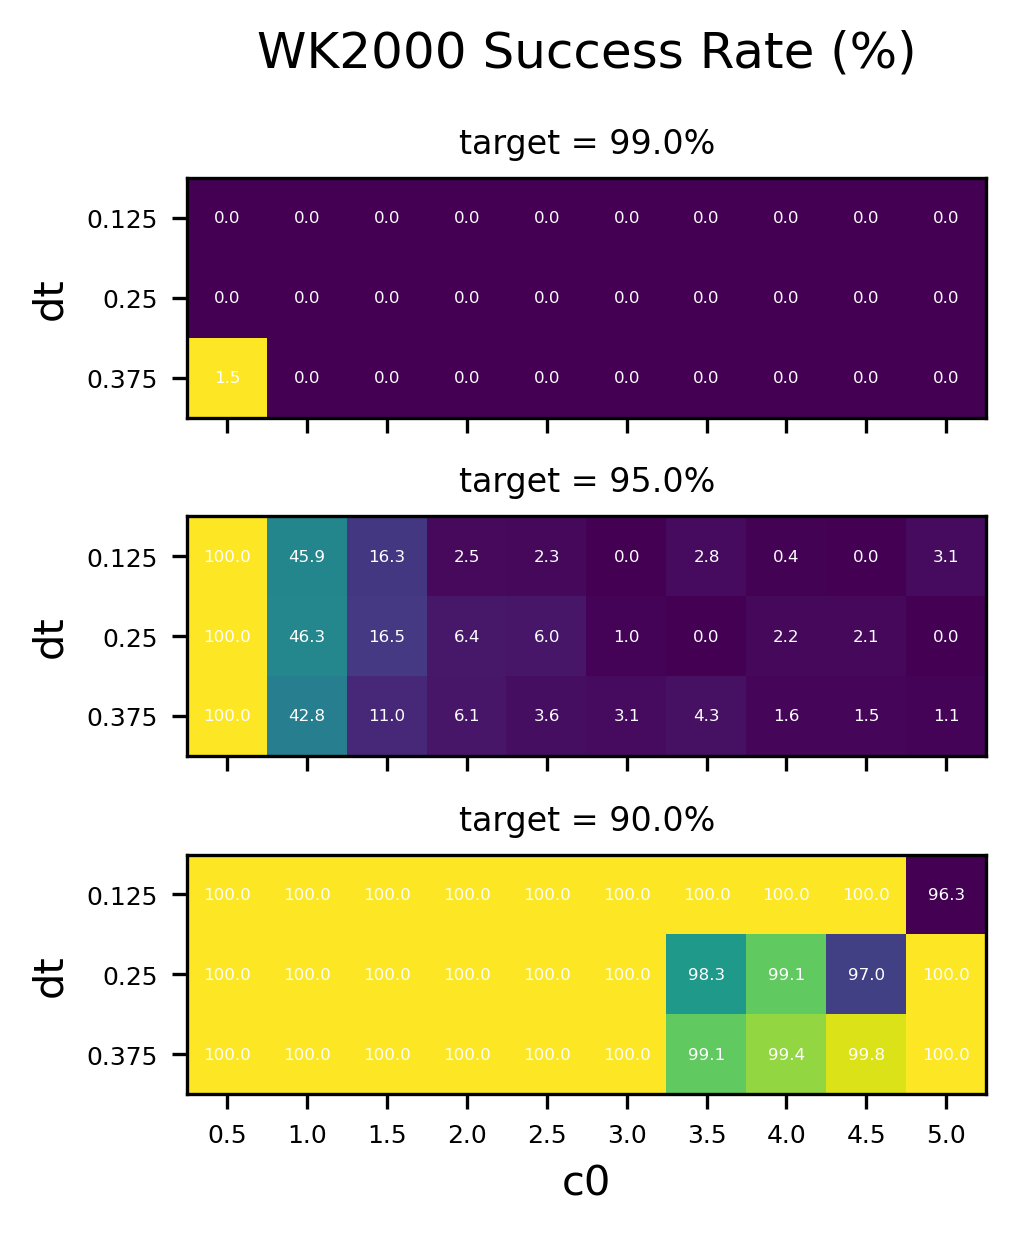

In [213]:
fig, axs = plt.subplots(3, 1, dpi=300, constrained_layout=True, sharex=True, sharey=True)
fig.suptitle("WK2000 Success Rate (%)")
plt.setp(axs[-1], xlabel="c0")
plt.setp(axs[:], ylabel="dt")

for i, r in enumerate([0.99, 0.95, 0.9]):
    ax = axs[i]
    best_cut_count_data = np.zeros((len(dt_lst), len(c0_lst)))
    total_count_data = np.zeros((len(dt_lst), len(c0_lst)))
    for ins in range(10):
        for x, c0 in enumerate(c0_lst):
            for y, dt in enumerate(dt_lst):
                best_cut_count_data[y, x] += sum([x >= r * opt_cut_WK2000 for x in data[(dt, c0)]])
                total_count_data[y, x] += len(data[(dt, c0)])

    success_rate_data = best_cut_count_data / total_count_data

    ax.imshow(success_rate_data)

    ax.set_xticks(np.arange(len(c0_lst)))
    ax.set_yticks(np.arange(len(dt_lst)))
    ax.set_xticklabels(c0_lst, size=6)
    ax.set_yticklabels(dt_lst, size=6)
    # ax.set_xlabel("c0")
    # ax.set_ylabel("dt")
    ax.set_title(f"target = {100*r}%", size=8)

    # Loop over data dimensions and create text annotations.
    for i in range(len(dt_lst)):
        for j in range(len(c0_lst)):
            text = ax.text(j, i, f"{100*success_rate_data[i, j]:.1f}",
                        ha="center", va="center", color="w", size=4)

## FPGA validation

In [251]:
def non_sym_sgn(x):
    return np.array([1 if v > 0 else -1 for v in x])

In [266]:
def test(J, PS, dt, c0, h=None, init_y=None, sd=None, return_x_history=False):
    """
    One discrete simulated bifurcation run over the full pump schedule.
    Angular frequency (a0) is set to 1 and absorbed into PS, dt and c0.
    Objective: Minimize J.dot(state).dot(state) + h.dot(state)
    
    Parameters:
        J (2-D array of float): The matrix representing the coupling field of the problem.
        PS (list[float]): The pump strength at each step. Number of iterations is implicitly len(PS).
        dt (float): Time step for the discretized time.
        c0 (float): Positive coupling strength scaling factor.
        h (1-D array of float or None, default=None): The vector representing the local field of the problem.
        init_y (1-D array of float or None, default=None): Initial y. If None, then random numbers between 0.1 and -0.1 are chosen.
        sd (int or None, default=None): Seed for rng of init_y.
        return_x_history (bool, default=False): True to return history of x additionally.
    
    Return: final_state (1-D array of float)
    """
    
    if h is None:
        j = J
    else:
        j = np.zeros((J.shape[0]+1, J.shape[1]+1))
        j[:-1, :-1] = J
        j[:-1, -1] = 0.5*h
        j[-1, :-1] = 0.5*h.T
    
    x = np.zeros(j.shape[0])

    if init_y is None:
        np.random.seed(sd)
        y = np.random.uniform(-0.1, 0.1, j.shape[0])
    else:
        y = init_y.copy()
    
    if return_x_history:
        x_history = []
    
    for a in PS:
        y -= ((1 - a) * x + 2 * c0 * j.dot(non_sym_sgn(x))) * dt
        x += y * dt
        for i in range(j.shape[0]): # parallelizable
            if np.abs(x[i]) > 1:
                x[i] = np.sign(x[i])
                y[i] = 0
        
        if return_x_history:
            x_history.append(x.copy()) # for analysis purposes

    if return_x_history:
        if h is None:
            return np.sign(x), x_history
        else:
            return np.sign(x[:-1]) * np.sign(x[-1]), x_history
    
    if h is None:
        return np.sign(x)
    else:
        return np.sign(x[:-1]) * np.sign(x[-1])

In [267]:
# abs_file_path = f"/home/r09222027/GitHub/Annealing-Algorithms/Simulated Bifurcation/mac_all/rudy/g05_{N}.{ins}" # absolute dir
# J = Ising_from_maxcut_file(abs_file_path)
J = J_dict[(60, 0)]

j = J / (np.sqrt(np.sum(J**2) / (J.shape[0] - 1))) # normalization

dt = 0.25
steps = int(150/dt)
ps = [i/(steps-1) for i in range(steps)] # linear schedule from 0 to 1

init_y = 0.01 * np.ones(j.shape[0])

fin_state, x_hist = test(j, ps, dt, 3, init_y=init_y, return_x_history=True)

In [268]:
fin_state == 1

array([False,  True,  True, False,  True,  True, False,  True,  True,
        True, False,  True, False, False,  True,  True, False,  True,
        True, False,  True, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False,  True,  True, False, False, False, False,  True, False,
        True, False,  True,  True,  True,  True, False,  True, False,
       False,  True,  True,  True,  True,  True])

In [269]:
x_hist

[array([0.42802924, 0.4029981 , 0.39048254, 0.32790471, 0.45306037,
        0.39048254, 0.35293584, 0.34042028, 0.36545141, 0.4029981 ,
        0.36545141, 0.42802924, 0.35293584, 0.36545141, 0.32790471,
        0.34042028, 0.37796697, 0.34042028, 0.32790471, 0.35293584,
        0.34042028, 0.35293584, 0.39048254, 0.37796697, 0.31538914,
        0.31538914, 0.36545141, 0.37796697, 0.4029981 , 0.39048254,
        0.45306037, 0.36545141, 0.39048254, 0.41551367, 0.31538914,
        0.34042028, 0.41551367, 0.4405448 , 0.39048254, 0.35293584,
        0.27784245, 0.22778018, 0.4029981 , 0.42802924, 0.37796697,
        0.35293584, 0.36545141, 0.42802924, 0.39048254, 0.35293584,
        0.36545141, 0.32790471, 0.4029981 , 0.27784245, 0.4029981 ,
        0.36545141, 0.4780915 , 0.36545141, 0.37796697, 0.39048254]),
 array([0.40382207, 0.38035277, 0.36861812, 0.30994488, 0.42729137,
        0.36861812, 0.33341418, 0.32167953, 0.34514883, 0.38035277,
        0.34514883, 0.40382207, 0.33341418, 0.